In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

In [2]:
df = pd.read_csv("data_clean.csv", sep=",")
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price,Trip_Distance_km_log,Trip_Price_log
0,19.35000,Morning,Weekday,3.0,Low,Clear,3.560000,0.80,0.32,53.82,36.2600,3.013081,3.617920
1,47.59000,Afternoon,Weekday,1.0,High,Clear,3.500522,0.62,0.43,40.57,29.5058,3.883418,3.417917
2,36.87000,Evening,Weekend,1.0,High,Clear,2.700000,1.21,0.15,37.27,52.9000,3.634159,3.987130
3,30.33000,Evening,Weekday,4.0,Low,Clear,3.480000,0.51,0.15,116.81,36.4700,3.444576,3.623541
4,8.26455,Evening,Weekday,3.0,High,Clear,2.930000,0.63,0.32,22.64,15.6200,2.226195,2.810607


# Linear Model

## Prepare data with proper one-hot encoding for categorical variables

In [3]:
# Create a copy to avoid modifying the original dataframe
df_model = df.copy()

# Drop the original non-log transformed columns
df_model = df_model.drop(['Trip_Distance_km', 'Trip_Price'], axis=1)

# Create dummy variables for categorical columns
categorical_columns = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']

# Create dummies and drop first category for each variable
for column in categorical_columns:
    dummies = pd.get_dummies(df_model[column], prefix=column, drop_first=True)
    df_model = pd.concat([df_model, dummies], axis=1)
    df_model = df_model.drop(column, axis=1)

df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Passenger_Count            983 non-null    float64
 1   Base_Fare                  983 non-null    float64
 2   Per_Km_Rate                983 non-null    float64
 3   Per_Minute_Rate            983 non-null    float64
 4   Trip_Duration_Minutes      983 non-null    float64
 5   Trip_Distance_km_log       983 non-null    float64
 6   Trip_Price_log             983 non-null    float64
 7   Time_of_Day_Evening        983 non-null    uint8  
 8   Time_of_Day_Morning        983 non-null    uint8  
 9   Time_of_Day_Night          983 non-null    uint8  
 10  Day_of_Week_Weekend        983 non-null    uint8  
 11  Traffic_Conditions_Low     983 non-null    uint8  
 12  Traffic_Conditions_Medium  983 non-null    uint8  
 13  Weather_Rain               983 non-null    uint8  

In [4]:
df_model.head()

,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Distance_km_log,Trip_Price_log,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Day_of_Week_Weekend,Traffic_Conditions_Low,Traffic_Conditions_Medium,Weather_Rain,Weather_Snow
0,3.0,3.560000,0.80,0.32,53.82,3.013081,3.617920,0,1,0,0,1,0,0,0
1,1.0,3.500522,0.62,0.43,40.57,3.883418,3.417917,0,0,0,0,0,0,0,0
2,1.0,2.700000,1.21,0.15,37.27,3.634159,3.987130,1,0,0,1,0,0,0,0
3,4.0,3.480000,0.51,0.15,116.81,3.444576,3.623541,1,0,0,0,1,0,0,0
4,3.0,2.930000,0.63,0.32,22.64,2.226195,2.810607,1,0,0,0,0,0,0,0


In [5]:
# Separate features and target
X = df_model.drop('Trip_Price_log', axis=1)
y = df_model['Trip_Price_log']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features only
numerical_columns = ['Trip_Distance_km_log', 'Passenger_Count', 'Base_Fare', 
                    'Per_Km_Rate', 'Per_Minute_Rate', 'Trip_Duration_Minutes']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

## Train and analyze linear regression model

In [6]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit the model
model = sm.OLS(y_train, X_train_sm).fit()

# Print summary
print("\nModel Summary:")
print(model.summary())


Model Summary:
                            OLS Regression Results                            
Dep. Variable:         Trip_Price_log   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     170.3
Date:                Tue, 21 Jan 2025   Prob (F-statistic):          1.07e-224
Time:                        18:46:05   Log-Likelihood:                -121.97
No. Observations:                 786   AIC:                             273.9
Df Residuals:                     771   BIC:                             343.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const 

## Evaluate model predictions

In [8]:
# Add constant for prediction
X_test_sm = sm.add_constant(X_test)

# Make predictions
y_pred = model.predict(X_test_sm)

# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = model.rsquared

# Calculate metrics on actual price scale
actual_prices = np.exp(y_test)
predicted_prices = np.exp(y_pred)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Mean Squared Error: 0.0957
Root Mean Squared Error: 0.3094
R-squared: 0.7557
Mean Absolute Percentage Error: 21.82%


## Diagnostic plots for linear regression

In [9]:
# Get residuals and fitted values
residuals = model.resid
fitted_values = model.fittedvalues

Text(0.5, 1.0, 'Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

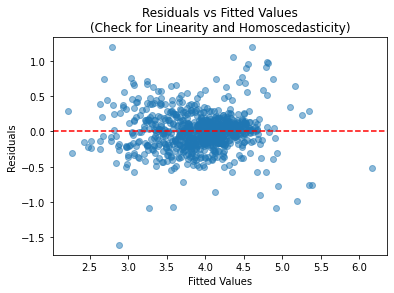

In [10]:
# 1. Residuals vs Fitted Values
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values\n(Check for Linearity and Homoscedasticity)')

Text(0.5, 1.0, 'Q-Q Plot\n(Check for Normality of Residuals)')

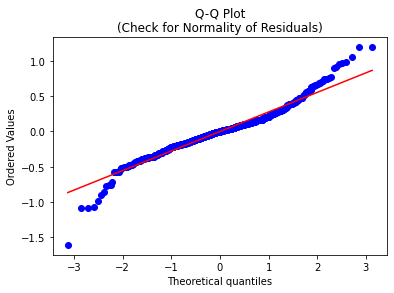

In [11]:
# 2. Q-Q Plot for Normality
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Check for Normality of Residuals)')

Text(0.5, 1.0, 'Histogram of Residuals\n(Check for Normality)')

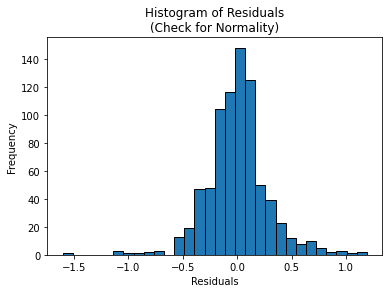

In [12]:
# 3. Residuals Histogram
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals\n(Check for Normality)')

Text(0.5, 1.0, 'Correlation Heatmap\n(Check for Multicollinearity)')

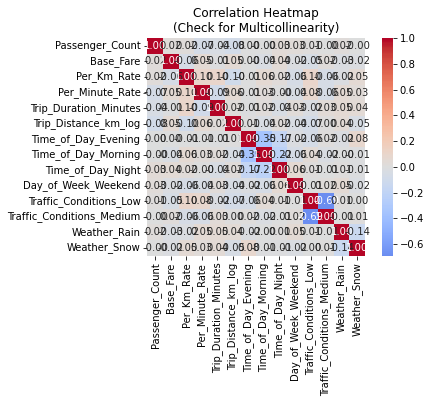

In [13]:
# 4. Correlation Heatmap
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=True, fmt='.2f', square=True)
plt.title('Correlation Heatmap\n(Check for Multicollinearity)')